# Classical monetary approach

## purchasing power parity - purchasing price index

multistep: mutistpe forecast  
m: montly data

### dependent variable

- "DEXJPUS","fred"

### independent variable

- "PPIACO","fred"
- "PITGCG01JPM661N","fred"

In [1]:
%matplotlib inline
import datetime
import pandas_datareader.data as web
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mean_squared_error
from scipy.stats import norm
from statsmodels.tsa.api import VECM
start="1971/1/1";end='2019/12/31'
from dateutil.relativedelta import relativedelta
from scipy.stats import t
from scipy.stats import norm
def tcdf(x,n): #t-distribution
    if x>=0:
        y=(1-t.cdf(x,n))
    else:
        y=t.cdf(x,n)
    return y
def ncdf(x): #t-distribution
    if x>=0:
        y=(1-norm.cdf(x))
    else:
        y=norm.cdf(x)
    return y

In [2]:
e =web.DataReader("DEXJPUS","fred",start,end)
p1 =web.DataReader("USACPIALLMINMEI","fred",start,end)#m
p2 =web.DataReader("JPNCPIALLMINMEI","fred",start,end)#m
p3 =web.DataReader("PPIACO","fred",start,end)#m
p4 =web.DataReader("PITGCG01JPM661N","fred",start,end)#m

In [3]:
ee=e.copy().resample('MS').last()
tsd=pd.concat([ee,p3,p4],axis=1)
tsd.columns=['ee','p1','p2']
print(tsd.head())
print(tsd.tail())

                ee    p1         p2
DATE                               
1971-01-01  357.72  37.3  67.280863
1971-02-01  357.56  37.7  67.280863
1971-03-01  357.42  37.8  67.379515
1971-04-01  357.40  37.9  67.478167
1971-05-01  357.40  38.1  67.774124
                ee     p1    p2
DATE                           
2019-08-01  106.30  199.2  95.4
2019-09-01  108.11  198.4  95.5
2019-10-01  108.09  198.6  95.3
2019-11-01  109.47  199.0  95.3
2019-12-01  108.67  199.2  95.7


In [4]:
def backtest_ols_dp(tsd,tw,pt):#tw time window pt:predicting time
    pred=[]
    real0=[]
    real9=[]
    tsd0=np.log(tsd).copy()
    for i in range(tw+1,len(tsd)+1-1):
        yy=tsd0.iloc[i-tw:i:1,0]
        y0=tsd0.iloc[i-tw-1:i:1,0].diff().dropna()
        x0=(tsd0.iloc[i-tw-1:i:1,1]-tsd0.iloc[i-tw-1:i:1,2]).diff().dropna()
        x0=sm.add_constant(x0.values)
        res= sm.OLS(y0, x0).fit()
        real0.append(np.exp(tsd0.iloc[i-1:i,0][-1]))
        if i<len(tsd)+1-pt:
            x9=(tsd0.iloc[i-1:i+pt:1,1]-tsd0.iloc[i-1:i+pt:1,2]).diff().dropna()
            if pt==1:
                x9=np.insert(x9.values,0,1)
            else:
                x9=sm.add_constant(x9.values)
            pred0=res.predict(x9)[-1:]
            pred.append(np.exp(pred0+yy.iloc[-1]))
            real9.append(np.exp(tsd0.iloc[i+pt-1:i+pt:1,0].values))
    return real0,real9,pred

def performance_eval(real0,real9,pred):
    p0=pd.DataFrame(real0)
    p9=pd.DataFrame(real9)
    pp=pd.DataFrame(pred)
    p0_=p0[:len(p9)]
    pp_=pp[:len(p9)]
    wrs=p0_[(p9<p0_)&(pp_<p0_)].count()
    wrl=p0_[(p9>p0_)&(pp_>p0_)].count()
    wr=float((wrs+wrl)/p0_.count())
    #wrp=tcdf(float((wr-0.5)/np.sqrt(0.25/p0_.count())),p0_.count())[0]
    wrp=ncdf(float((wr-0.5)/np.sqrt(0.25/p0_.count())))
    d_x=(pp_-p9)**2
    d_rw=(p9-p0_)**2
    d=d_x-d_rw
    d_=float(d.mean())
    #dm=tcdf(float(d_/np.sqrt(((d-d_)**2).sum()/len(d)**2)),p0_.count())[0]
    dm=ncdf(float(d_/np.sqrt(((d-d_)**2).sum()/len(d)**2)))
    rmse=float(d_x.mean()/d_rw.mean())
    return rmse,dm,wr,wrp

def performance_report(real0,real9,pred):
    ab,dm,wr,wrp=performance_eval(real0,real9,pred)
    print('{0:20s}{1:5d} mse_r {2:7.4f} mse_p {3:7.2f} wr {4:7.4f} wrp {5:7.2f} len {6:4d}'
          .format(model,isp,ab,dm,wr,wrp,len(real9)))    

In [5]:
pstart=datetime.date(1983,1,1)
pend=datetime.date(1994,12,31)        
model='first difference OLS'
oosp=3
nn=len(tsd.loc[pstart:pend])
for isp in range(oosp*10,oosp*50,12):#10,pt):
    ps=pstart-relativedelta(months=isp*1-1)
    tsdd=tsd.loc[ps:pend]
    if (len(tsdd)-isp==nn) or (len(tsdd)-isp==nn-1):
        real0,real9,pred=backtest_ols_dp(tsdd,isp,oosp)
        performance_report(real0,real9,pred)

first difference OLS   30 mse_r  1.0050 mse_p    0.44 wr  0.5357 wrp    0.20 len  140
first difference OLS   42 mse_r  1.0049 mse_p    0.44 wr  0.5071 wrp    0.43 len  140
first difference OLS   54 mse_r  1.0451 mse_p    0.02 wr  0.4714 wrp    0.25 len  140
first difference OLS   66 mse_r  1.0220 mse_p    0.15 wr  0.5143 wrp    0.37 len  140
first difference OLS   78 mse_r  1.0114 mse_p    0.34 wr  0.5071 wrp    0.43 len  140
first difference OLS   90 mse_r  1.0008 mse_p    0.49 wr  0.5071 wrp    0.43 len  140
first difference OLS  102 mse_r  0.9869 mse_p    0.26 wr  0.5571 wrp    0.09 len  140
first difference OLS  114 mse_r  0.9791 mse_p    0.14 wr  0.5571 wrp    0.09 len  140
first difference OLS  126 mse_r  0.9832 mse_p    0.17 wr  0.5429 wrp    0.16 len  140
first difference OLS  138 mse_r  0.9891 mse_p    0.27 wr  0.5429 wrp    0.16 len  140


In [6]:
pstart=datetime.date(1995,1,1)
pend=datetime.date(2007,12,31)        
model='first difference OLS'
oosp=3
nn=len(tsd.loc[pstart:pend])
for isp in range(oosp*10,oosp*50,18):#10,pt):
    ps=pstart-relativedelta(months=isp*1-1)
    tsdd=tsd.loc[ps:pend]
    if (len(tsdd)-isp==nn) or (len(tsdd)-isp==nn-1):
        real0,real9,pred=backtest_ols_dp(tsdd,isp,oosp)
        performance_report(real0,real9,pred)

first difference OLS   30 mse_r  0.9893 mse_p    0.37 wr  0.5066 wrp    0.44 len  152
first difference OLS   48 mse_r  0.9956 mse_p    0.45 wr  0.5263 wrp    0.26 len  152
first difference OLS   66 mse_r  0.9704 mse_p    0.25 wr  0.5855 wrp    0.02 len  152
first difference OLS   84 mse_r  0.9851 mse_p    0.36 wr  0.5329 wrp    0.21 len  152
first difference OLS  102 mse_r  0.9852 mse_p    0.37 wr  0.5592 wrp    0.07 len  152
first difference OLS  120 mse_r  0.9998 mse_p    0.50 wr  0.5263 wrp    0.26 len  152
first difference OLS  138 mse_r  1.0136 mse_p    0.34 wr  0.5197 wrp    0.31 len  152


In [7]:
pstart=datetime.date(2008,1,1)
pend=datetime.date(2020,12,31)        
model='first difference OLS'
oosp=3
nn=len(tsd.loc[pstart:pend])
for isp in range(oosp*10,oosp*50,18):#10,pt):
    ps=pstart-relativedelta(months=isp*1-1)
    tsdd=tsd.loc[ps:pend]
    if (len(tsdd)-isp==nn) or (len(tsdd)-isp==nn-1):
        real0,real9,pred=backtest_ols_dp(tsdd,isp,oosp)
        performance_report(real0,real9,pred)

first difference OLS   30 mse_r  0.9347 mse_p    0.10 wr  0.5714 wrp    0.05 len  140
first difference OLS   48 mse_r  0.9526 mse_p    0.13 wr  0.5714 wrp    0.05 len  140
first difference OLS   66 mse_r  0.9720 mse_p    0.20 wr  0.5786 wrp    0.03 len  140
first difference OLS   84 mse_r  1.0159 mse_p    0.24 wr  0.5643 wrp    0.06 len  140
first difference OLS  102 mse_r  1.0203 mse_p    0.16 wr  0.5857 wrp    0.02 len  140
first difference OLS  120 mse_r  1.0273 mse_p    0.07 wr  0.5786 wrp    0.03 len  140
first difference OLS  138 mse_r  1.0346 mse_p    0.07 wr  0.5571 wrp    0.09 len  140


In [8]:
pstart=datetime.date(1983,1,1)
pend=datetime.date(1994,12,31)        
model='first difference OLS'
oosp=12
nn=len(tsd.loc[pstart:pend])
for isp in range(oosp*10,oosp*50,6):#10,pt):
    ps=pstart-relativedelta(months=isp*1-1)
    tsdd=tsd.loc[ps:pend]
    if (len(tsdd)-isp==nn) or (len(tsdd)-isp==nn-1):
        real0,real9,pred=backtest_ols_dp(tsdd,isp,oosp)
        performance_report(real0,real9,pred)

first difference OLS  120 mse_r  0.9801 mse_p    0.00 wr  0.7099 wrp    0.00 len  131
first difference OLS  126 mse_r  0.9799 mse_p    0.00 wr  0.7099 wrp    0.00 len  131
first difference OLS  132 mse_r  0.9793 mse_p    0.00 wr  0.7099 wrp    0.00 len  131
first difference OLS  138 mse_r  0.9879 mse_p    0.00 wr  0.6947 wrp    0.00 len  131
first difference OLS  144 mse_r  0.9903 mse_p    0.00 wr  0.7176 wrp    0.00 len  131


In [9]:
pstart=datetime.date(1995,1,1)
pend=datetime.date(2007,12,31)        
model='first difference OLS'
oosp=12
nn=len(tsd.loc[pstart:pend])
for isp in range(oosp*10,oosp*50,18):#10,pt):
    ps=pstart-relativedelta(months=isp*1-1)
    tsdd=tsd.loc[ps:pend]
    if (len(tsdd)-isp==nn) or (len(tsdd)-isp==nn-1):
        real0,real9,pred=backtest_ols_dp(tsdd,isp,oosp)
        performance_report(real0,real9,pred)

first difference OLS  120 mse_r  0.9523 mse_p    0.02 wr  0.5105 wrp    0.40 len  143
first difference OLS  138 mse_r  0.9669 mse_p    0.05 wr  0.4615 wrp    0.18 len  143
first difference OLS  156 mse_r  0.9674 mse_p    0.04 wr  0.4755 wrp    0.28 len  143
first difference OLS  174 mse_r  0.9738 mse_p    0.04 wr  0.4895 wrp    0.40 len  143
first difference OLS  192 mse_r  0.9794 mse_p    0.07 wr  0.4755 wrp    0.28 len  143
first difference OLS  210 mse_r  0.9836 mse_p    0.09 wr  0.4615 wrp    0.18 len  143
first difference OLS  228 mse_r  0.9902 mse_p    0.18 wr  0.4685 wrp    0.23 len  143
first difference OLS  246 mse_r  0.9977 mse_p    0.41 wr  0.4545 wrp    0.14 len  143
first difference OLS  264 mse_r  0.9960 mse_p    0.32 wr  0.4545 wrp    0.14 len  143
first difference OLS  282 mse_r  0.9989 mse_p    0.44 wr  0.4615 wrp    0.18 len  143


In [10]:
pstart=datetime.date(2008,1,1)
pend=datetime.date(2020,12,31)        
model='first difference OLS'
oosp=12
nn=len(tsd.loc[pstart:pend])
for isp in range(oosp*10,oosp*50,24):#10,pt):
    ps=pstart-relativedelta(months=isp*1-1)
    tsdd=tsd.loc[ps:pend]
    if (len(tsdd)-isp==nn) or (len(tsdd)-isp==nn-1):
        real0,real9,pred=backtest_ols_dp(tsdd,isp,oosp)
        performance_report(real0,real9,pred)

first difference OLS  120 mse_r  1.0040 mse_p    0.18 wr  0.5420 wrp    0.17 len  131
first difference OLS  144 mse_r  0.9977 mse_p    0.28 wr  0.5420 wrp    0.17 len  131
first difference OLS  168 mse_r  0.9941 mse_p    0.12 wr  0.5496 wrp    0.13 len  131
first difference OLS  192 mse_r  0.9898 mse_p    0.02 wr  0.5802 wrp    0.03 len  131
first difference OLS  216 mse_r  0.9779 mse_p    0.00 wr  0.6412 wrp    0.00 len  131
first difference OLS  240 mse_r  0.9780 mse_p    0.00 wr  0.6412 wrp    0.00 len  131
first difference OLS  264 mse_r  0.9798 mse_p    0.00 wr  0.5878 wrp    0.02 len  131
first difference OLS  288 mse_r  0.9722 mse_p    0.00 wr  0.6260 wrp    0.00 len  131
first difference OLS  312 mse_r  0.9723 mse_p    0.00 wr  0.6489 wrp    0.00 len  131
first difference OLS  336 mse_r  0.9830 mse_p    0.00 wr  0.5802 wrp    0.03 len  131
first difference OLS  360 mse_r  0.9860 mse_p    0.01 wr  0.6031 wrp    0.01 len  131
first difference OLS  384 mse_r  0.9844 mse_p    0.00 

In [11]:
pstart=datetime.date(1983,1,1)
pend=datetime.date(1994,12,31)        
model='first difference OLS'
oosp=60
nn=len(tsd.loc[pstart:pend])
for isp in range(oosp*1,oosp*50,12):#10,pt):
    ps=pstart-relativedelta(months=isp*1-1)
    tsdd=tsd.loc[ps:pend]
    if (len(tsdd)-isp==nn) or (len(tsdd)-isp==nn-1):
        real0,real9,pred=backtest_ols_dp(tsdd,isp,oosp)
        performance_report(real0,real9,pred)

first difference OLS   60 mse_r  1.0031 mse_p    0.30 wr  0.7108 wrp    0.00 len   83
first difference OLS   72 mse_r  0.9966 mse_p    0.25 wr  0.7470 wrp    0.00 len   83
first difference OLS   84 mse_r  0.9907 mse_p    0.02 wr  0.7831 wrp    0.00 len   83
first difference OLS   96 mse_r  0.9870 mse_p    0.00 wr  0.8072 wrp    0.00 len   83
first difference OLS  108 mse_r  0.9874 mse_p    0.00 wr  0.7831 wrp    0.00 len   83
first difference OLS  120 mse_r  0.9890 mse_p    0.00 wr  0.8434 wrp    0.00 len   83
first difference OLS  132 mse_r  0.9895 mse_p    0.00 wr  0.8675 wrp    0.00 len   83
first difference OLS  144 mse_r  0.9876 mse_p    0.00 wr  0.9036 wrp    0.00 len   83


In [12]:
pstart=datetime.date(1995,1,1)
pend=datetime.date(2007,12,31)        
model='first difference OLS'
oosp=60
nn=len(tsd.loc[pstart:pend])
for isp in range(oosp*1,oosp*50,18):#10,pt):
    ps=pstart-relativedelta(months=isp*1-1)
    tsdd=tsd.loc[ps:pend]
    if (len(tsdd)-isp==nn) or (len(tsdd)-isp==nn-1):
        real0,real9,pred=backtest_ols_dp(tsdd,isp,oosp)
        performance_report(real0,real9,pred)

first difference OLS   60 mse_r  1.0348 mse_p    0.27 wr  0.5053 wrp    0.46 len   95
first difference OLS   78 mse_r  1.0208 mse_p    0.34 wr  0.4947 wrp    0.46 len   95
first difference OLS   96 mse_r  0.9944 mse_p    0.45 wr  0.5263 wrp    0.30 len   95
first difference OLS  114 mse_r  0.9900 mse_p    0.39 wr  0.5368 wrp    0.24 len   95
first difference OLS  132 mse_r  1.0151 mse_p    0.31 wr  0.4842 wrp    0.38 len   95
first difference OLS  150 mse_r  0.9963 mse_p    0.44 wr  0.5158 wrp    0.38 len   95
first difference OLS  168 mse_r  0.9900 mse_p    0.32 wr  0.5368 wrp    0.24 len   95
first difference OLS  186 mse_r  0.9796 mse_p    0.14 wr  0.5158 wrp    0.38 len   95
first difference OLS  204 mse_r  0.9815 mse_p    0.13 wr  0.4526 wrp    0.18 len   95
first difference OLS  222 mse_r  0.9890 mse_p    0.22 wr  0.4842 wrp    0.38 len   95
first difference OLS  240 mse_r  0.9968 mse_p    0.40 wr  0.4526 wrp    0.18 len   95
first difference OLS  258 mse_r  0.9896 mse_p    0.18 

In [13]:
pstart=datetime.date(2008,1,1)
pend=datetime.date(2020,12,31)        
model='first difference OLS'
oosp=60
nn=len(tsd.loc[pstart:pend])
for isp in range(oosp*1,oosp*50,36):#10,pt):
    ps=pstart-relativedelta(months=isp*1-1)
    tsdd=tsd.loc[ps:pend]
    if (len(tsdd)-isp==nn) or (len(tsdd)-isp==nn-1):
        real0,real9,pred=backtest_ols_dp(tsdd,isp,oosp)
        performance_report(real0,real9,pred)

first difference OLS   60 mse_r  1.0294 mse_p    0.00 wr  0.1807 wrp    0.00 len   83
first difference OLS   96 mse_r  1.0214 mse_p    0.00 wr  0.0241 wrp    0.00 len   83
first difference OLS  132 mse_r  1.0118 mse_p    0.00 wr  0.0602 wrp    0.00 len   83
first difference OLS  168 mse_r  1.0070 mse_p    0.00 wr  0.3735 wrp    0.01 len   83
first difference OLS  204 mse_r  1.0001 mse_p    0.48 wr  0.4699 wrp    0.29 len   83
first difference OLS  240 mse_r  1.0030 mse_p    0.12 wr  0.3855 wrp    0.02 len   83
first difference OLS  276 mse_r  1.0035 mse_p    0.08 wr  0.4217 wrp    0.08 len   83
first difference OLS  312 mse_r  1.0106 mse_p    0.00 wr  0.2771 wrp    0.00 len   83
first difference OLS  348 mse_r  1.0123 mse_p    0.00 wr  0.1928 wrp    0.00 len   83
first difference OLS  384 mse_r  1.0113 mse_p    0.00 wr  0.1807 wrp    0.00 len   83
first difference OLS  420 mse_r  1.0126 mse_p    0.00 wr  0.1566 wrp    0.00 len   83


In [14]:
def backtest_VECM(tsd,tw,pt,det):#tw time window pt:predicting time
    pred=[]
    real0=[]
    real9=[]
    tsd0=np.log(tsd.copy())
    for i in range(tw,len(tsd)+1):
        y0=(tsd0.iloc[i-tw:i:1,0])
        x=tsd0.iloc[i-tw:i:1,1]-tsd0.iloc[i-tw:i:1,2]
        tsd00=pd.concat([y0,x],axis=1)
        model = VECM(tsd00,k_ar_diff=0,deterministic=det)
        results = model.fit() 
        real0.append(np.exp(y0.iloc[-1]))
        pp=np.exp(results.predict(pt)[-1][0])
        pred.append(pp)
        if i<len(tsd)+1-pt:
            real9.append(tsd.iloc[i+pt-1,0])
    return real0,real9,pred

In [15]:
pstart=datetime.date(1983,1,1)
pend=datetime.date(1994,12,31)        
nn=len(tsd.loc[pstart:pend])
interval=1
model='VECM'
oosp=3
for isp in range(oosp*20,oosp*200,oosp*5):#10,pt):
    ps=pstart-relativedelta(months=isp*interval-1)
    tsdd=tsd.loc[ps:pend]
    if (len(tsdd)-isp==nn) or (len(tsdd)-isp==nn-1):
        real0,real9,pred=backtest_VECM(tsdd,isp,oosp,'li')
        performance_report(real0,real9,pred)

VECM                   60 mse_r  1.1558 mse_p    0.07 wr  0.5745 wrp    0.04 len  141
VECM                   75 mse_r  0.9980 mse_p    0.48 wr  0.5319 wrp    0.22 len  141
VECM                   90 mse_r  1.0717 mse_p    0.02 wr  0.5461 wrp    0.14 len  141
VECM                  105 mse_r  1.0377 mse_p    0.16 wr  0.5887 wrp    0.02 len  141
VECM                  120 mse_r  0.9484 mse_p    0.12 wr  0.5816 wrp    0.03 len  141
VECM                  135 mse_r  0.8812 mse_p    0.02 wr  0.5957 wrp    0.01 len  141


In [16]:
pstart=datetime.date(1995,1,1)
pend=datetime.date(2007,12,31)        
nn=len(tsd.loc[pstart:pend])
interval=1
model='VECM'
oosp=3
for isp in range(oosp*20,oosp*200,oosp*10):#10,pt):
    ps=pstart-relativedelta(months=isp*interval-1)
    tsdd=tsd.loc[ps:pend]
    if (len(tsdd)-isp==nn) or (len(tsdd)-isp==nn-1):
        real0,real9,pred=backtest_VECM(tsdd,isp,oosp,'na')
        performance_report(real0,real9,pred)

VECM                   60 mse_r  1.0881 mse_p    0.05 wr  0.4510 wrp    0.11 len  153
VECM                   90 mse_r  1.0184 mse_p    0.32 wr  0.3922 wrp    0.00 len  153
VECM                  120 mse_r  1.0178 mse_p    0.16 wr  0.4510 wrp    0.11 len  153
VECM                  150 mse_r  1.0729 mse_p    0.00 wr  0.4118 wrp    0.01 len  153
VECM                  180 mse_r  1.0686 mse_p    0.00 wr  0.4118 wrp    0.01 len  153
VECM                  210 mse_r  1.0306 mse_p    0.06 wr  0.4118 wrp    0.01 len  153
VECM                  240 mse_r  1.0341 mse_p    0.02 wr  0.4118 wrp    0.01 len  153
VECM                  270 mse_r  1.0347 mse_p    0.02 wr  0.4183 wrp    0.02 len  153


In [17]:
pstart=datetime.date(2008,1,1)
pend=datetime.date(2020,12,31)        
nn=len(tsd.loc[pstart:pend])
interval=1
model='VECM'
oosp=3
for isp in range(oosp*20,oosp*200,oosp*10):#10,pt):
    ps=pstart-relativedelta(months=isp*interval-1)
    tsdd=tsd.loc[ps:pend]
    if (len(tsdd)-isp==nn) or (len(tsdd)-isp==nn-1):
        real0,real9,pred=backtest_VECM(tsdd,isp,oosp,'na')
        performance_report(real0,real9,pred)

VECM                   60 mse_r  1.0725 mse_p    0.01 wr  0.5248 wrp    0.28 len  141
VECM                   90 mse_r  1.0297 mse_p    0.17 wr  0.5177 wrp    0.34 len  141
VECM                  120 mse_r  0.9871 mse_p    0.25 wr  0.5390 wrp    0.18 len  141
VECM                  150 mse_r  1.0060 mse_p    0.32 wr  0.5035 wrp    0.47 len  141
VECM                  180 mse_r  1.0215 mse_p    0.03 wr  0.4823 wrp    0.34 len  141
VECM                  210 mse_r  0.9996 mse_p    0.49 wr  0.5035 wrp    0.47 len  141
VECM                  240 mse_r  1.0048 mse_p    0.35 wr  0.5603 wrp    0.08 len  141
VECM                  270 mse_r  1.0229 mse_p    0.07 wr  0.4610 wrp    0.18 len  141
VECM                  300 mse_r  1.0042 mse_p    0.41 wr  0.4965 wrp    0.47 len  141
VECM                  330 mse_r  1.0265 mse_p    0.11 wr  0.5035 wrp    0.47 len  141
VECM                  360 mse_r  1.0391 mse_p    0.05 wr  0.5035 wrp    0.47 len  141
VECM                  390 mse_r  1.0273 mse_p    0.14 

(144, 141, 144)

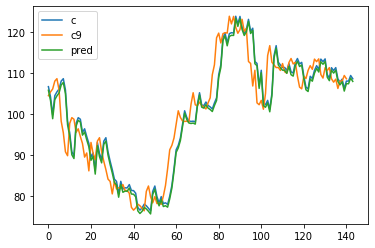

In [18]:
plt.plot(real0[:],label='c')
plt.plot(real9[:],label='c9')
plt.plot(pred[:],label='pred')
plt.legend()
len(real0),len(real9),len(pred)

In [19]:
pstart=datetime.date(1983,1,1)
pend=datetime.date(1994,12,31)        
nn=len(tsd.loc[pstart:pend])
interval=1
model='VECM'
oosp=12
for isp in range(oosp*2,oosp*200,oosp*2):#10,pt):
    ps=pstart-relativedelta(months=isp*interval-1)
    tsdd=tsd.loc[ps:pend]
    if (len(tsdd)-isp==nn) or (len(tsdd)-isp==nn-1):
        real0,real9,pred=backtest_VECM(tsdd,isp,oosp,'li')
        performance_report(real0,real9,pred)

VECM                   24 mse_r  1.3824 mse_p    0.00 wr  0.5833 wrp    0.03 len  132
VECM                   48 mse_r  1.3966 mse_p    0.02 wr  0.6742 wrp    0.00 len  132
VECM                   72 mse_r  1.0941 mse_p    0.04 wr  0.6439 wrp    0.00 len  132
VECM                   96 mse_r  1.1095 mse_p    0.01 wr  0.6667 wrp    0.00 len  132
VECM                  120 mse_r  0.8122 mse_p    0.00 wr  0.7652 wrp    0.00 len  132
VECM                  144 mse_r  0.6310 mse_p    0.00 wr  0.7652 wrp    0.00 len  132


In [20]:
pstart=datetime.date(1995,1,1)
pend=datetime.date(2007,12,31)        
nn=len(tsd.loc[pstart:pend])
interval=1
model='VECM'
oosp=12
for isp in range(oosp*2,oosp*200,oosp*1):#10,pt):
    ps=pstart-relativedelta(months=isp*interval-1)
    tsdd=tsd.loc[ps:pend]
    if (len(tsdd)-isp==nn) or (len(tsdd)-isp==nn-1):
        real0,real9,pred=backtest_VECM(tsdd,isp,oosp,'ci')
        performance_report(real0,real9,pred)

VECM                   24 mse_r  1.8465 mse_p    0.00 wr  0.5486 wrp    0.12 len  144
VECM                   36 mse_r  1.3213 mse_p    0.05 wr  0.5833 wrp    0.02 len  144
VECM                   48 mse_r  1.4997 mse_p    0.01 wr  0.4931 wrp    0.43 len  144
VECM                   60 mse_r  1.1372 mse_p    0.16 wr  0.5833 wrp    0.02 len  144
VECM                   72 mse_r  1.2603 mse_p    0.05 wr  0.6042 wrp    0.01 len  144
VECM                   84 mse_r  0.9265 mse_p    0.11 wr  0.6042 wrp    0.01 len  144
VECM                   96 mse_r  1.0548 mse_p    0.22 wr  0.5486 wrp    0.12 len  144
VECM                  108 mse_r  1.1681 mse_p    0.01 wr  0.5000 wrp    0.50 len  144
VECM                  120 mse_r  1.1873 mse_p    0.01 wr  0.5486 wrp    0.12 len  144
VECM                  132 mse_r  1.2275 mse_p    0.00 wr  0.5069 wrp    0.43 len  144
VECM                  144 mse_r  1.2452 mse_p    0.00 wr  0.4931 wrp    0.43 len  144
VECM                  156 mse_r  1.2806 mse_p    0.00 

In [21]:
pstart=datetime.date(2008,1,1)
pend=datetime.date(2020,12,31)        
nn=len(tsd.loc[pstart:pend])
interval=1
model='VECM'
oosp=12
for isp in range(oosp*2,oosp*200,oosp*2):#10,pt):
    ps=pstart-relativedelta(months=isp*interval-1)
    tsdd=tsd.loc[ps:pend]
    if (len(tsdd)-isp==nn) or (len(tsdd)-isp==nn-1):
        real0,real9,pred=backtest_VECM(tsdd,isp,oosp,'ci')
        performance_report(real0,real9,pred)

VECM                   24 mse_r  2.4233 mse_p    0.01 wr  0.3864 wrp    0.00 len  132
VECM                   48 mse_r  1.3411 mse_p    0.00 wr  0.5758 wrp    0.04 len  132
VECM                   72 mse_r  1.2860 mse_p    0.00 wr  0.3712 wrp    0.00 len  132
VECM                   96 mse_r  1.1829 mse_p    0.00 wr  0.5303 wrp    0.24 len  132
VECM                  120 mse_r  1.3202 mse_p    0.00 wr  0.3864 wrp    0.00 len  132
VECM                  144 mse_r  1.2861 mse_p    0.00 wr  0.3864 wrp    0.00 len  132
VECM                  168 mse_r  1.4392 mse_p    0.00 wr  0.2652 wrp    0.00 len  132
VECM                  192 mse_r  1.2107 mse_p    0.00 wr  0.3485 wrp    0.00 len  132
VECM                  216 mse_r  1.0829 mse_p    0.03 wr  0.6288 wrp    0.00 len  132
VECM                  240 mse_r  1.0347 mse_p    0.15 wr  0.5833 wrp    0.03 len  132
VECM                  264 mse_r  1.0594 mse_p    0.00 wr  0.5985 wrp    0.01 len  132
VECM                  288 mse_r  1.0482 mse_p    0.01 

In [22]:
pstart=datetime.date(1983,1,1)
pend=datetime.date(1994,12,31)        
nn=len(tsd.loc[pstart:pend])
nnn=len(tsd)

interval=1
model='VECM'
oosp=60
for isp in range(36,oosp*200,12):#10,pt):
    ps=pstart-relativedelta(months=isp*interval-1)
    tsdd=tsd.loc[ps:pend]
    if (len(tsdd)-isp==nn) or (len(tsdd)-isp==nn-1):
        real0,real9,pred=backtest_VECM(tsdd,isp,oosp,'li')
        performance_report(real0,real9,pred)
    if len(tsdd)+isp>=nnn:
        break

VECM                   36 mse_r  1.4151 mse_p    0.01 wr  0.9286 wrp    0.00 len   84
VECM                   48 mse_r  1.4864 mse_p    0.00 wr  0.8690 wrp    0.00 len   84
VECM                   60 mse_r  1.6211 mse_p    0.00 wr  0.8333 wrp    0.00 len   84
VECM                   72 mse_r  1.1242 mse_p    0.06 wr  0.7857 wrp    0.00 len   84
VECM                   84 mse_r  0.7725 mse_p    0.01 wr  0.7976 wrp    0.00 len   84
VECM                   96 mse_r  0.5483 mse_p    0.00 wr  0.7857 wrp    0.00 len   84
VECM                  108 mse_r  0.3464 mse_p    0.00 wr  0.8571 wrp    0.00 len   84
VECM                  120 mse_r  0.1669 mse_p    0.00 wr  0.9405 wrp    0.00 len   84
VECM                  132 mse_r  0.2457 mse_p    0.00 wr  0.9881 wrp    0.00 len   84
VECM                  144 mse_r  0.3781 mse_p    0.00 wr  0.9881 wrp    0.00 len   84


In [23]:
pstart=datetime.date(1995,1,1)
pend=datetime.date(2007,12,31)        
nn=len(tsd.loc[pstart:pend])
interval=1
model='VECM'
oosp=60
for isp in range(60,oosp*200,12):#10,pt):
    ps=pstart-relativedelta(months=isp*interval-1)
    tsdd=tsd.loc[ps:pend]
    if (len(tsdd)-isp==nn) or (len(tsdd)-isp==nn-1):
        real0,real9,pred=backtest_VECM(tsdd,isp,oosp,'ci')
        performance_report(real0,real9,pred)
    if len(tsdd)+isp>=nnn:
        break        

VECM                   60 mse_r  5.5014 mse_p    0.00 wr  0.5625 wrp    0.11 len   96
VECM                   72 mse_r 31.8217 mse_p    0.08 wr  0.5312 wrp    0.27 len   96
VECM                   84 mse_r  6.1293 mse_p    0.00 wr  0.5208 wrp    0.34 len   96
VECM                   96 mse_r  3.5354 mse_p    0.00 wr  0.4375 wrp    0.11 len   96
VECM                  108 mse_r  2.6877 mse_p    0.00 wr  0.3854 wrp    0.01 len   96
VECM                  120 mse_r  3.0278 mse_p    0.00 wr  0.4375 wrp    0.11 len   96
VECM                  132 mse_r  3.1649 mse_p    0.00 wr  0.3750 wrp    0.01 len   96
VECM                  144 mse_r  2.9473 mse_p    0.00 wr  0.3542 wrp    0.00 len   96
VECM                  156 mse_r  2.6121 mse_p    0.00 wr  0.3333 wrp    0.00 len   96
VECM                  168 mse_r  2.4917 mse_p    0.00 wr  0.3958 wrp    0.02 len   96
VECM                  180 mse_r  2.2909 mse_p    0.00 wr  0.3958 wrp    0.02 len   96
VECM                  192 mse_r  2.0102 mse_p    0.00 

In [24]:
pstart=datetime.date(2008,1,1)
pend=datetime.date(2020,12,31)        
nn=len(tsd.loc[pstart:pend])
interval=1
model='VECM'
oosp=60
for isp in range(oosp*1,oosp*200,12):#10,pt):
    ps=pstart-relativedelta(months=isp*interval-1)
    tsdd=tsd.loc[ps:pend]
    if (len(tsdd)-isp==nn) or (len(tsdd)-isp==nn-1):
        real0,real9,pred=backtest_VECM(tsdd,isp,oosp,'ci')
        performance_report(real0,real9,pred)
    if len(tsdd)+isp>=nnn:
        break        

VECM                   60 mse_r  2.1720 mse_p    0.00 wr  0.2500 wrp    0.00 len   84
VECM                   72 mse_r  1.5244 mse_p    0.00 wr  0.4048 wrp    0.04 len   84
VECM                   84 mse_r  1.3775 mse_p    0.00 wr  0.4167 wrp    0.06 len   84
VECM                   96 mse_r  1.5547 mse_p    0.00 wr  0.2381 wrp    0.00 len   84
VECM                  108 mse_r  1.7751 mse_p    0.00 wr  0.2738 wrp    0.00 len   84
VECM                  120 mse_r  1.7249 mse_p    0.00 wr  0.3333 wrp    0.00 len   84
VECM                  132 mse_r  1.6730 mse_p    0.00 wr  0.2500 wrp    0.00 len   84
VECM                  144 mse_r  1.6305 mse_p    0.00 wr  0.2857 wrp    0.00 len   84
VECM                  156 mse_r  1.5995 mse_p    0.00 wr  0.4048 wrp    0.04 len   84
VECM                  168 mse_r  1.6001 mse_p    0.00 wr  0.4524 wrp    0.19 len   84
VECM                  180 mse_r  1.3722 mse_p    0.01 wr  0.4762 wrp    0.33 len   84
VECM                  192 mse_r  1.1727 mse_p    0.09 